### SAIRAM

In [1]:
import os
import numpy as np
from dotenv import load_dotenv
load_dotenv()

True

In [18]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.tools.retriever import create_retriever_tool
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

from typing import TypedDict, List, Annotated, Sequence

In [3]:
embeddings = OpenAIEmbeddings()
len(embeddings.embed_query("Hey"))


llm = ChatOpenAI()
llm.invoke("Hey!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BxaN8zOoVNaQTr4IvEcwtPHwuOGFM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--68791c52-6e5d-4ca9-84e4-92847fb3b1a1-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
urls = ['https://puffy.com/pages/puffy-mattress-and-puffy-lux?via=menu_header_mattress',
        'https://puffy.com/products/puffy-mattress?via=menu_item_mattresses_puffy-mattress_desktop',
        'https://puffy.com/products/puffy-lux-mattress?via=menu_item_mattresses_puffy-lux-mattress_desktop',
        'https://puffy.com/products/puffy-royal-mattress?via=menu_item_mattresses_puffy-royal-mattress_desktop',
        'https://puffy.com/products/puffy-monarch-mattress?via=menu_item_mattresses_puffy-monarch-mattress_desktop',
        'https://puffy.com/collections/smart-bed-sets?via=menu_header_smartbeds',
        'https://puffy.com/products/puffy-cloud-smart-bed-set?via=menu_item_smartbeds_puffy-cloud-smart-bed-set_desktop',
        'https://puffy.com/products/puffy-lux-smart-bed-set?via=menu_item_smartbeds_puffy-lux-smart-bed-set_desktop',
        'https://puffy.com/products/puffy-royal-smart-bed-set?via=menu_item_smartbeds_puffy-royal-smart-bed-set_desktop',
        'https://puffy.com/collections/bed-frames?via=menu_header_bedframes',
        'https://puffy.com/products/puffy-adjustable-base?via=menu_item_bedframes_puffy-adjustable-base_desktop',
        'https://puffy.com/products/puffy-milan-bed-frame?via=menu_item_bedframes_puffy-milan-bed-frame_desktop',
        'https://puffy.com/products/puffy-bed-frame?via=menu_item_bedframes_puffy-bed-frame_desktop',
        'https://puffy.com/products/puffy-capri-bed-frame?via=menu_item_bedframes_puffy-capri-bed-frame_desktop',
        'https://puffy.com/products/puffy-zen-bed-frame?via=menu_item_bedframes_puffy-zen-bed-frame_desktop',
        'https://puffy.com/products/puffy-dusk-bed-frame?via=menu_item_bedframes_puffy-dusk-bed-frame_desktop',
        'https://puffy.com/products/puffy-foundation?via=menu_item_bedframes_puffy-foundation_desktop',
        'https://puffy.com/collections/bedding?via=menu_header_beddings',
        'https://puffy.com/products/puffy-topper?via=menu_item_beddings_puffy-topper_desktop',
        'https://puffy.com/products/puffy-sheets?via=menu_item_beddings_puffy-sheets_desktop',
        'https://puffy.com/products/puffy-mattress-protector?via=menu_item_beddings_puffy-mattress-protector_desktop',
        'https://puffy.com/products/puffy-pillow?via=menu_item_beddings_puffy-pillow_desktop',
        'https://puffy.com/products/puffy-mattress-pad?via=menu_item_beddings_puffy-mattress-pad_desktop',
        'https://puffy.com/products/puffy-comforter?via=menu_item_beddings_puffy-comforter_desktop',
        'https://puffy.com/products/puffy-area-rug?via=menu_item_beddings_puffy-area-rug_desktop',
        'https://puffy.com/products/puffy-blanket?via=menu_item_beddings_puffy-blanket_desktop',
        'https://puffy.com/products/puffy-weighted-blanket?via=menu_item_beddings_puffy-weighted-blanket_desktop',
        'https://puffy.com/products/puffy-sleep-mask?via=menu_item_beddings_puffy-sleep-mask_desktop',
        'https://puffy.com/products/puffy-sectional?via=menu_item_beddings_puffy-sectional_desktop'
        ]

In [5]:
loader=WebBaseLoader(urls)
docs = loader.load()
print(len(docs))

docs[3].page_content

29


"Official Puffy® Royal Mattress | Ranked #1 Luxury MattressMENUMATTRESSESSMART BEDSBED FRAMESBEDDING & MOREREVIEWSPUFFY VSSUPPORTSTORES0\n\n\n\nPuffy RoyalExperience the #1 Award-Winning Ultra-Luxury MattressEndorsed by  the ACABest Soft  Mattress 2025Best Hybrid  Mattress for Pressure Relief  2025Best Ultra Luxury  Mattress 2025Puffy ROYAL MattressHybridRated 5 stars by 12,000+ sleepersAVAILABLE UPGRADES:ComparePuffy ROYALMattressHybrid10 LayersUltra-Plush5-Zoned Support Foam & CoilsNot Offered in TwinUltimate LuxuryPuffy MONARCHMattressHybrid12 LayersLuxury-PlushPremium Alpaca Wool & LatexCHOOSE YOUR SIZE:Size guideTwinTwin XLFullQueenKingCal KingSplit King(Total Value  $2,499)$1,149with code JULYSALEJULY SALEADD TO CART100% money-back guarantee. Order today for delivery by Jul 30 - Aug 4.FREE 2 PILLOWS & SLEEP MASK:$315 FREE2 Signature Memory  Foam PillowS$240Signature  Sleep Mask$75Need  help ordering? Call now.Talk 1-on-1 with our support specialist.Talk 1-on-1 with our support sp

In [6]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=400, chunk_overlap=20)
#text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=0)
split_docs = text_splitter.split_documents(docs)
print(len(split_docs))
print(split_docs[10].page_content)

92
Puffy RoyalExperience the #1 Award-Winning Ultra-Luxury MattressEndorsed by  the ACABest Soft  Mattress 2025Best Hybrid  Mattress for Pressure Relief  2025Best Ultra Luxury  Mattress 2025Puffy ROYAL MattressHybridRated 5 stars by 12,000+ sleepersAVAILABLE UPGRADES:ComparePuffy ROYALMattressHybrid10 LayersUltra-Plush5-Zoned Support Foam & CoilsNot Offered in TwinUltimate LuxuryPuffy MONARCHMattressHybrid12 LayersLuxury-PlushPremium Alpaca Wool & LatexCHOOSE YOUR SIZE:Size guideTwinTwin XLFullQueenKingCal KingSplit King(Total Value  $2,499)$1,149with code JULYSALEJULY SALEADD TO CART100% money-back guarantee. Order today for delivery by Jul 30 - Aug 4.FREE 2 PILLOWS & SLEEP MASK:$315 FREE2 Signature Memory  Foam PillowS$240Signature  Sleep Mask$75Need  help ordering? Call now.Talk 1-on-1 with our support specialist.Talk 1-on-1 with our support specialist.Call +1 (800) 430-8380orChat With UsMade  in USA.Free shipping. In 1 - 2 days.101-night  sleep trial.Warranty. For life.ProductsMATT

In [7]:
vector_store = Chroma.from_documents(
                documents=split_docs,
                collection_name="puffy_lumous",
                embedding=embeddings
                )
vector_store

In [8]:
vector_store.similarity_search("do you have sofa?")

[Document(metadata={'language': 'en', 'title': 'Official Puffy® Soho Sectional Sofa | Lounge-Worthy Luxury', 'source': 'https://puffy.com/products/puffy-sectional?via=menu_item_beddings_puffy-sectional_desktop', 'description': 'Official Puffy SoHo Sectional Sofa: Experience exceptional lounging with plush velvet, modular versatility, and lasting luxury. Designed for comfort.'}, page_content='Official Puffy® Soho Sectional Sofa | Lounge-Worthy LuxuryMENUMATTRESSESSMART BEDSBED FRAMESBEDDING & MOREREVIEWSPUFFY VSSUPPORTSTORES0'),
 Document(metadata={'description': 'Official Puffy SoHo Sectional Sofa: Experience exceptional lounging with plush velvet, modular versatility, and lasting luxury. Designed for comfort.', 'title': 'Official Puffy® Soho Sectional Sofa | Lounge-Worthy Luxury', 'source': 'https://puffy.com/products/puffy-sectional?via=menu_item_beddings_puffy-sectional_desktop', 'language': 'en'}, page_content='Puffy SoHo Sectional Sofa4 Seater + Ottoman / IvoryADD TO CART$2,9994 S

In [9]:
retriever = vector_store.as_retriever()
retriever.invoke(
    "are there any pillow for neck pain?"
)


[Document(metadata={'language': 'en', 'source': 'https://puffy.com/products/puffy-pillow?via=menu_item_beddings_puffy-pillow_desktop', 'title': 'Official Puffy® Pillow | Your Ultimate Luxury Pillow', 'description': 'Official Puffy Pillow: Enjoy deep sleep with the luxurious Puffy Pillow, designed for adjustable support and the perfect blend of softness and firmness.'}, page_content='Official Puffy® Pillow | Your Ultimate Luxury PillowMENUMATTRESSESSMART BEDSBED FRAMESBEDDING & MOREREVIEWSPUFFY VSSUPPORTSTORES0'),
 Document(metadata={'title': 'Official Puffy® Sleep Mask | Your Luxury Sleep Essential', 'language': 'en', 'source': 'https://puffy.com/products/puffy-sleep-mask?via=menu_item_beddings_puffy-sleep-mask_desktop', 'description': 'Official Puffy Signature Sleep Mask: Enhance your sleep quality with our comfortable, light-blocking mask. Experience luxury and a 101-night trial.'}, page_content='Official Puffy® Sleep Mask | Your Luxury Sleep EssentialMENUMATTRESSESSMART BEDSBED FRAM

In [10]:
retriever_tool = create_retriever_tool(retriever=retriever,
                         name="puffy_lumous",
                          description="Details about mattress, smart bed, bedframes, beddings & more"  + '\n\n'.join([doc.metadata['description'] for doc in docs])
                        
                        )
tools = [retriever_tool]
tools

[Tool(name='puffy_lumous', description="Details about mattress, smart bed, bedframes, beddings & moreDiscover the difference between the Puffy and Puffy Lux mattresses - Get the luxury sleep you deserve with our 101-night trial, free shipping, and lifetime warranty.\n\nOfficial Puffy Cloud Mattress: Sleep in luxury with cloudlike comfort and enjoy $1,350 in savings on the award-winning #1 Memory Foam Mattress 2025.\n\nOfficial Puffy Lux Hybrid Mattress: Ranked #1 Mattress-in-a-Box 2025, offers a luxurious blend of comfort and support. Start your 101-night sleep trial today.\n\nOfficial Puffy Royal Hybrid Mattress: ranked #1 Luxury Mattress 2025. The ultimate luxury sleep experience. Enjoy the best sleep of your life.\n\nOfficial Puffy Monarch Mattress: Experience unparalleled comfort with the evolution in sleep luxury. Enjoy $1,350 savings on top-rated 2025 Hybrid Mattress.\n\nOfficial Puffy Smart Bed Sets collection: Enjoy any award-winning Puffy mattress with our bestselling adjustab

In [64]:
class AgentState(TypedDict):
    lang: str
    user_query: str
    documents: List[str]
    messages: List[BaseMessage]
    llm_response: str
    
class QueryExtraction(BaseModel):
    lang: str=Field(description="language of the user question in the standard of ISO 639-1: Example EN for english; FR for french")
    translated: str=Field(defaullt=None, description="English translated query if user has entered non english question")

In [66]:
def supervisor(state:AgentState):
    print('<<--supervisor-->>', state["user_query"])
    llm_with_tools = llm.bind_tools(tools) 
    ai_message = llm_with_tools.invoke(state["user_query"])
    #print(f"response:{ai_message}")
    return {'messages': [ai_message]}

def extractor(state:AgentState):
    print('<<--extractor-->>', state['user_query'])
    
    template = """
    You are a helpful assistant. Analyze the user query. Analyze the query and respond the language code(standard of ISO 639-1) of the query.
    Example EN for english; FR for french. For non english, translate the non-english query to english query.
    if the user is already in english then do nothing, populate empty space to translated field
    
    User_query: {user_query}
    """
    prompt = PromptTemplate(template=template,
                   input_variables=['user_query'])
    print('prompt:', prompt)
    chain = prompt | llm.with_structured_output(QueryExtraction)
    response=chain.invoke({'user_query':state['user_query']})
    
    if response.lang == 'EN':
        final_query = state['user_query']
    else:
        final_query = response.translated
        
    return {
        'lang'       : response.lang,
        'user_query' : final_query
    }

def conditional_router(state:AgentState):
    if state['lang'] == 'EN':
        return 'retriever'
    else:
        return 'retriever'
    
def run_retriever(state:AgentState):
    print('<<--retriever-->>', state['user_query'])
    query = state['user_query']
    docs = retriever.invoke(query)
    print(f'Query for retriever: {query} \n Retreived_docs: {docs}')
    return {"documents":docs} 

def synthesizer(state:AgentState):
    print('<<--synthesizer-->>', state['user_query'])
    template = """
    You are a helpful assistant. Based on the user query regarding Puffy product, I will provide you the context 
    from which you need to generate the response along with the actual user query.
    Follow below instructions
    1) Try to be precise, 
    2) recommend the relevant product as per the user requirement, 
    3) share the cost for the product & offer if any,
    4) tell me importance/significance of the product
    5) provide the links to read further or buy the product.
    
    \n
    User_query: {user_query}
    context   : {documents}
    """
    prompt = PromptTemplate(template=template,
                   input_variables=['user_query', 'documents'])
    print('prompt:', prompt)
    chain = prompt | llm
    response=chain.invoke({'user_query':state['user_query'],
                           'documents' :state['documents']
                               })
    print(response)
    return {'llm_response':response}
    

In [80]:
os.getcwd()

'd:\\Generative AI\\Puffy Lumous\\research'

In [81]:
vector_store = Chroma(
    collection_name="puffy_lumous",  # ✅ Must match
    embedding_function=embeddings,
    persist_directory="../puffy_chroma_store"  # ✅ Must match
)
retriever = vector_store.as_retriever()

In [85]:
print("Number of vectors:", vector_store._collection.count())  # Check if DB has vectors
results = vector_store.similarity_search("mattress", k=3)

Number of vectors: 1012


In [84]:
retriever.invoke('My room measures 12 m². What bed frame would be best?')

[Document(metadata={'description': 'Official Puffy collection of luxury bed frames, foundations, and adjustable bases. Elevate your sleep experience. Shop now for ultimate support and style.', 'source': 'https://puffy.com/collections/bed-frames?via=menu_header_bedframes', 'language': 'en', 'title': 'Official Puffy® Luxury Bed Frames, Adjustable Bases & Foundations'}, page_content='DUSK Bed Frame 34 ReviewsLuxuriously sleek mattress support with long-lasting comfort.Strong 100% steel framePlush velvet coverUp to 13" under-bed storageStarts at$269 With SavingsSHOP NOWJULY SALE15% OffPuffy MIDNIGHT Foundation 643 ReviewsStrong and functional support for your mattress.15" storage spaceAssembles in minutesLightweightStarts at$152 With SavingsSHOP NOW6 Reasons To Shop PuffyREASON 1Best July Sale offers.Get the best deals on our high-quality mattresses, bed frames, and bedroom accessories.REASON 2Easy financing options.Choose mattress financing as low as 0% APR with Affirm.REASON 3Made in USA

In [42]:
state = {'user_query':'what mattress is good?'}
#response=supervisor(state)
#print(response)
#run_retriever(state)

synthesizer(state= {'user_query':'what mattress is good?', 'documents': run_retriever({'user_query':'what mattress is good?'})})

#response=extractor(state)
#print(response)

<<--retriever-->> what mattress is good?
Query for retriever: what mattress is good? 
 Retreived_docs: [Document(metadata={'title': 'Official Puffy® Lux Hybrid Mattress | Ranked #1 Luxury Mattress', 'language': 'en', 'source': 'https://puffy.com/products/puffy-lux-mattress?via=menu_item_mattresses_puffy-lux-mattress_desktop', 'description': 'Official Puffy Lux Hybrid Mattress: Ranked #1 Mattress-in-a-Box 2025, offers a luxurious blend of comfort and support. Start your 101-night sleep trial today.'}, page_content='Puffy Lux1M+ Sold. Sleep on Our Award-Winning Luxury MattressBest Mattress  2025Best Luxury  Mattress  2025Best Soft  Mattress-in-a-Box  2025Best Mattress  for Back Pain  2025Puffy LUX MattressHybridRated 5 stars AVAILABLE UPGRADES:ComparePuffy LUXMattressHybrid8 LayersMedium-PlushMemory Foam & Wrapped Coils+ $350Premium ChoicePuffy ROYALMattressHybrid10 LayersUltra-Plush5-Zoned Support Foam & CoilsCHOOSE YOUR SIZE:Size guideTwinTwin XLFullQueenKingCal KingSplit King(Total Va

{'llm_response': AIMessage(content="Response:\nBased on your query, the Puffy Lux Hybrid Mattress is a highly recommended choice. It is ranked as the #1 Luxury Mattress and offers a luxurious blend of comfort and support. This mattress is perfect for those seeking a medium-plush feel with 8 layers including memory foam and wrapped coils.\n\nCost & Offer:\nThe Puffy Lux Hybrid Mattress is priced at $799 but you can avail an additional discount with the code JULYSALE. The total value of this mattress is $2,149 but you can get it for $799 with the offer. Additionally, with your purchase, you will receive 2 free pillows and a sleep mask worth $315.\n\nImportance/Significance:\nThis mattress is designed to provide ultimate comfort and support for a restful night's sleep. It has received high ratings and is perfect for back pain relief.\n\nFor further details or to make a purchase, you can visit the official Puffy Lux Hybrid Mattress page: [Puffy Lux Hybrid Mattress](https://puffy.com/produc

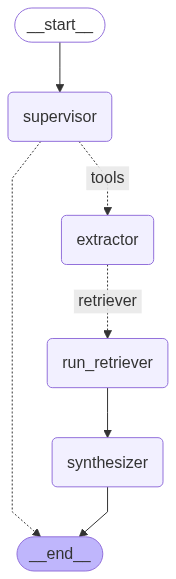

In [67]:
workflow = StateGraph(AgentState)
workflow.add_node("supervisor", supervisor)
workflow.add_node("extractor", extractor)
workflow.add_node("run_retriever", run_retriever)
workflow.add_node("synthesizer", synthesizer)

workflow.add_edge(START, "supervisor")
workflow.add_conditional_edges("supervisor", 
                               tools_condition, 
                               {'tools': "extractor",
                                END: END
                                }
                               )
#workflow.add_edge("supervisor", "extractor")
workflow.add_conditional_edges("extractor",
                               conditional_router,
                               {
                                   'retriever':'run_retriever'
                               }
                               )
workflow.add_edge('run_retriever', 'synthesizer')
workflow.add_edge('synthesizer', END)
workflow.compile()

In [69]:
q = 'what mattress is good?'
q = 'Quelle est la meilleure base de lit ajustable pour une chambre de 12 mètres carrés?'
state = {'user_query':q}
app=workflow.compile()
response = app.invoke(state)

<<--supervisor-->> Quelle est la meilleure base de lit ajustable pour une chambre de 12 mètres carrés?
<<--extractor-->> Quelle est la meilleure base de lit ajustable pour une chambre de 12 mètres carrés?
prompt: input_variables=['user_query'] input_types={} partial_variables={} template='\n    You are a helpful assistant. Analyze the user query. Analyze the query and respond the language code(standard of ISO 639-1) of the query.\n    Example EN for english; FR for french. For non english, translate the non-english query to english query.\n    if the user is already in english then do nothing, populate empty space to translated field\n\n    User_query: {user_query}\n    '


c:\Users\SAIRAM\anaconda3\envs\agentic2.0\Lib\site-packages\langchain_openai\chat_models\base.py:1690: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


<<--retriever-->> What is the best adjustable bed base for a 12 square meter room?
Query for retriever: What is the best adjustable bed base for a 12 square meter room? 
 Retreived_docs: [Document(metadata={'source': 'https://puffy.com/products/puffy-adjustable-base?via=menu_item_bedframes_puffy-adjustable-base_desktop', 'language': 'en', 'description': 'Official Puffy Adjustable Base: Elevate your comfort with the adjustable bed base. Achieve zero gravity and perfect pressure relief at the touch of a button.', 'title': 'Official Puffy® Adjustable Base | Luxury Base for Your Mattress'}, page_content='Puffy SERENITY Adjustable BaseTwin XLADD TO CART$1,199Twin XL  38"W x 80"L x 15"H$1,499$1,199ADD TO CARTPuffy Serenity Adjustable BasePremium Comfort Control at the Touch of a ButtonPuffy SERENITY Adjustable BaseRated 5 stars CHOOSE YOUR SIZE:Size guideTwin XLFullQueenSplit King(Total Value  $1,499)$1,199with savingsBuy with a mattress and save $300 $500ADD TO CARTAdd a mattress:$3,249 $1,